**Gita Rayung Andadari**
</br>gitarayung.andadari@studenti.unipd.it 
</br>2041509

# Initialization

In [22]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [23]:
%%capture
get_dbn_library()

In [24]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
import torch.nn.functional as functional
import tqdm


from DBN import DBN

lbl=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# Data Preparation

In [25]:
#Training set 
%%capture
emnist_train = tv.datasets.EMNIST('data/', train=True, download=True,split = 'letters',
                                        transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor()]
                                        ))

emnist_test = tv.datasets.EMNIST('data/', train=False, download=True,split = 'letters',
                                        transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor()]
                                        ))

In [26]:
#greyscaling 
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

In [27]:
emnist_data_train = emnist_train.data
emnist_targets_train = emnist_train.targets - 1 #for convenience, because python index starts at 0 
emnist_data_test = emnist_test.data 
emnist_targets_test = emnist_test.targets - 1

#Data Analysis

In [28]:
emnist_train

Dataset EMNIST
    Number of datapoints: 124800
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [29]:
emnist_test

Dataset EMNIST
    Number of datapoints: 20800
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

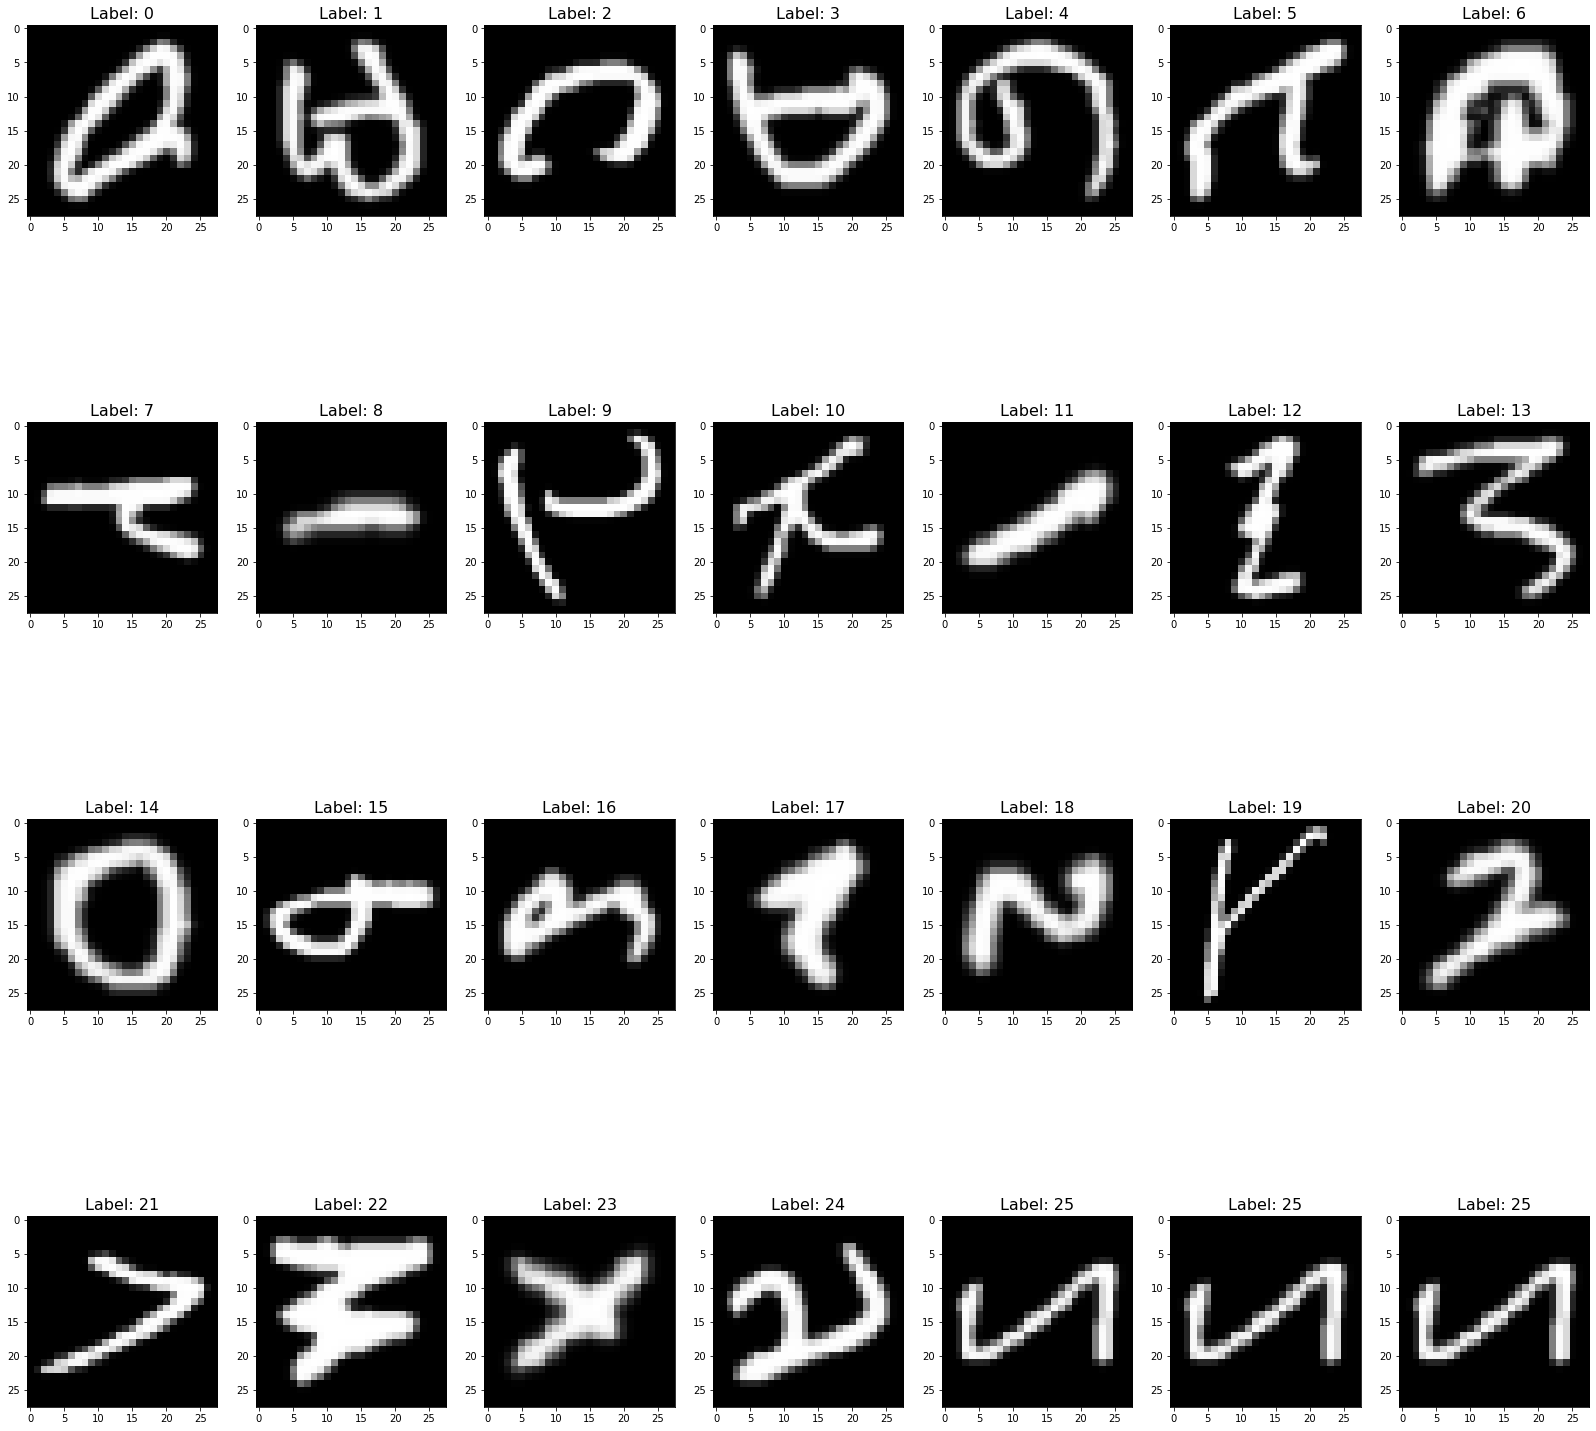

In [30]:
#sample from each classes 

num_classes = 26
f, ax = plt.subplots(4, 7, figsize=(28,28))
i=0
for a in ax:
  for k in range(7):
#    a.imshow(img, interpolation='none')
    for j in range(len(emnist_data_train)):
      if emnist_targets_train[j] == i:
        sample = emnist_data_train[j]
        i+=1
        break  
    a[k].imshow(sample, cmap='gray')
    a[k].set_title("Label: {}".format(i-1), fontsize=16)

#DBN

In [31]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 500,500], #this is 3 layers 
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False, 
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=False) #True

In [32]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9959   |0.0345   |315.4554 |5.8920   |
|20    |0.9504   |0.0332   |296.7995 |5.6668   |
|30    |0.9345   |0.0320   |290.1237 |5.3328   |
|40    |0.9294   |0.0311   |288.6611 |5.4133   |
|50    |0.9246   |0.0315   |285.7088 |5.6171   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0428   |0.0310   |214.4446 |3.2777   |
|20    |0.9953   |0.0295   |210.3074 |3.0876   |
|30    |0.9844   |0.0291   |209.3199 |3.2024   |
|40    |0.9786   |0.0293   |208.2592 |3.1168   |
|50    |0.9761   |0.0286   |208.2315 |3.2530   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9564   |0.0295   |211.2544 |3.5417   |
|20    |0.8696   |0.0270   |193.7786 |2.8847   |
|30    |0.8442   |0.0268   |189.6788 |3.1401   |
|40    |0.8331   |0.0269   |188.1619 |3.2761   |
|50    |0.8276

In [33]:
def _move_parameters_to_cpu(dbn_emnist):
  for layer in dbn_emnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [34]:
_move_parameters_to_cpu(dbn_emnist)

##Visualizing Receptive Fields 

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the EMNIST images we used for training. In this way, we will see what parts of an image trigger the unit represented by a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy.

In [35]:
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights):
  num_subplots = 4
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(4, 4))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot
    

In [36]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_3 = _apply_threshold(learned_weights_layer_3, 0)

learned_weights_product_2 = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product_2 = _apply_threshold(learned_weights_product_2, 0.1)

learned_weights_product_3 = (learned_weights_layer_1 @ learned_weights_layer_2 @ learned_weights_layer_3).T  # here we do the projection
learned_weights_product_3 = _apply_threshold(learned_weights_product_3, 0.2)


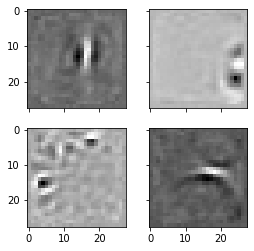

In [37]:
#plot of the weight in first layer 
_plot_layer_receptive_fields(learned_weights_layer_1.T)

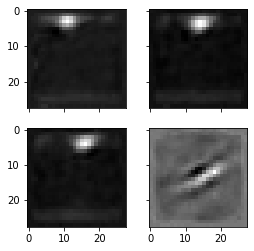

In [38]:
_plot_layer_receptive_fields(learned_weights_product_2)

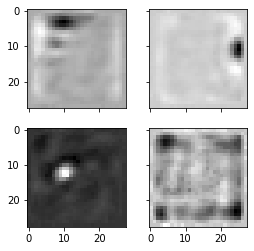

In [39]:
_plot_layer_receptive_fields(learned_weights_product_3)

##Clustering internal representations
Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the DBN contains internally several RBM objects. Therefore, we will need to compute the hidden representation using the weights of each RBM contained in the DBN.

In [40]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [41]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

for each weight (total 500), take the mean of the hidden representation from every data group by class 

In [42]:
def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(26)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(26)])

In [43]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)

In [44]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [45]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  lbl=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=lbl)
  ax.set_title(title)

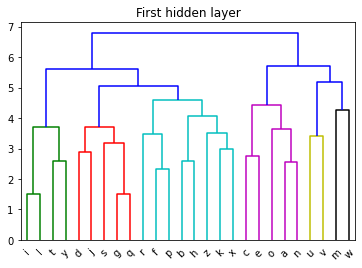

In [46]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

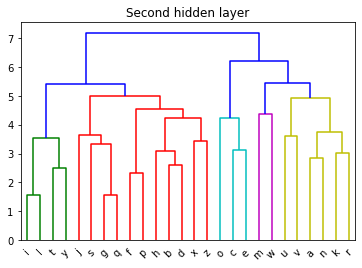

In [47]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

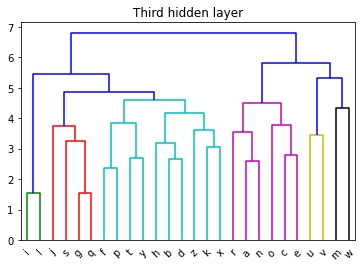

In [48]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

##Linear Read Out For 1, 2, and 3 layers DBN

In [49]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_targets_train)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [50]:
dbn_emnist.rbm_layers[0].W.shape

torch.Size([784, 500])

In [51]:
layer_size_1 = dbn_emnist.rbm_layers[0].W.shape[1]
layer_size_2 = dbn_emnist.rbm_layers[1].W.shape[0]
layer_size_3 = dbn_emnist.rbm_layers[2].W.shape[0]
print(layer_size_1,layer_size_2,layer_size_3)

500 500 500


In [52]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 26)

  def forward(self, x):
    return self.linear(x)

In [53]:
perceptron_1 = Perceptron(layer_size_1)
perceptron_2 = Perceptron(layer_size_2)
perceptron_3 = Perceptron(layer_size_3)

In [54]:
#training linear read out for the first layer 
_train(perceptron_1, hidden_repr_layer_1, epochs=1500)

epoch 0/1500, loss = 3.269725
epoch 100/1500, loss = 2.115722
epoch 200/1500, loss = 1.664706
epoch 300/1500, loss = 1.451875
epoch 400/1500, loss = 1.328850
epoch 500/1500, loss = 1.246809
epoch 600/1500, loss = 1.186760
epoch 700/1500, loss = 1.140015
epoch 800/1500, loss = 1.102045
epoch 900/1500, loss = 1.070241
epoch 1000/1500, loss = 1.042983
epoch 1100/1500, loss = 1.019199
epoch 1200/1500, loss = 0.998149
epoch 1300/1500, loss = 0.979304
epoch 1400/1500, loss = 0.962268


In [55]:
#training linear read out for the second layer 
_train(perceptron_2, hidden_repr_layer_2, epochs=1500)

epoch 0/1500, loss = 3.273711
epoch 100/1500, loss = 2.094566
epoch 200/1500, loss = 1.670390
epoch 300/1500, loss = 1.474432
epoch 400/1500, loss = 1.361053
epoch 500/1500, loss = 1.285093
epoch 600/1500, loss = 1.229275
epoch 700/1500, loss = 1.185699
epoch 800/1500, loss = 1.150233
epoch 900/1500, loss = 1.120487
epoch 1000/1500, loss = 1.094963
epoch 1100/1500, loss = 1.072673
epoch 1200/1500, loss = 1.052928
epoch 1300/1500, loss = 1.035234
epoch 1400/1500, loss = 1.019224


In [56]:
#training linear read out for the third layer 
_train(perceptron_3, hidden_repr_layer_3, epochs=1500)

epoch 0/1500, loss = 3.308648
epoch 100/1500, loss = 2.103561
epoch 200/1500, loss = 1.643390
epoch 300/1500, loss = 1.428203
epoch 400/1500, loss = 1.303882
epoch 500/1500, loss = 1.220811
epoch 600/1500, loss = 1.159881
epoch 700/1500, loss = 1.112373
epoch 800/1500, loss = 1.073742
epoch 900/1500, loss = 1.041368
epoch 1000/1500, loss = 1.013614
epoch 1100/1500, loss = 0.989400
epoch 1200/1500, loss = 0.967978
epoch 1300/1500, loss = 0.948809
epoch 1400/1500, loss = 0.931492


In [57]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)

In [58]:
predictions_test_1 = perceptron_1(hidden_repr_layer_1_test)
predictions_test_2 = perceptron_2(hidden_repr_layer_2_test)
predictions_test_3 = perceptron_3(hidden_repr_layer_3_test)

In [59]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [60]:
acc1 = _compute_accuracy(predictions_test_1, emnist_targets_test)
acc2 = _compute_accuracy(predictions_test_2, emnist_targets_test)
acc3 = _compute_accuracy(predictions_test_3, emnist_targets_test)

In [61]:
print('Accuracy DBN 1 layer + Linear Read Out : ', acc1)
print('Accuracy DBN 2 layer + Linear Read Out : ', acc2)
print('Accuracy DBN 3 layer + Linear Read Out : ', acc3)

Accuracy DBN 1 layer + Linear Read Out :  0.7336538434028625
Accuracy DBN 2 layer + Linear Read Out :  0.717596173286438
Accuracy DBN 3 layer + Linear Read Out :  0.7444230914115906


##Comparing DBN with Raw Perceptron

In [62]:
flattened_raw = emnist_data_train.view((emnist_data_train.shape[0], -1)).type(torch.FloatTensor)

In [63]:
flattened_raw.size()

torch.Size([124800, 784])

In [64]:
perceptron_4 = Perceptron(784)
_train(perceptron_4, flattened_raw, epochs=1500)

epoch 0/1500, loss = 3.281916
epoch 100/1500, loss = 2.050028
epoch 200/1500, loss = 1.688656
epoch 300/1500, loss = 1.531738
epoch 400/1500, loss = 1.442854
epoch 500/1500, loss = 1.384134
epoch 600/1500, loss = 1.341606
epoch 700/1500, loss = 1.308939
epoch 800/1500, loss = 1.282818
epoch 900/1500, loss = 1.261312
epoch 1000/1500, loss = 1.243212
epoch 1100/1500, loss = 1.227712
epoch 1200/1500, loss = 1.214250
epoch 1300/1500, loss = 1.202423
epoch 1400/1500, loss = 1.191930


In [65]:
flattened_raw_test = emnist_test.data.view((emnist_test.data.shape[0], -1)).type(torch.FloatTensor)
predictions_test_1 = perceptron_4(flattened_raw_test)
acc_raw = _compute_accuracy(predictions_test_1, emnist_targets_test)
print('Accuracy Raw Perceptron : ',acc_raw)

Accuracy Raw Perceptron :  0.6674038171768188


# Comparison with a feedforward model
Let's now train a simple feedforward neural network with the same structure as the RBM, i.e. with one hidden layer with `500` units.

We want to compare a network that is trained end-to-end to solve a classification task with a simple classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [66]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, first_hidden_layer_size, output_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, output_size)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [67]:
ffnn = Feedforward(input_size = 784,
    first_hidden_layer_size = 500,
    output_size = 26)

In [68]:
_train(ffnn, emnist_data_train.reshape((124800, 784)), epochs=170)

epoch 0/170, loss = 3.259089
epoch 10/170, loss = 3.205357
epoch 20/170, loss = 3.151444
epoch 30/170, loss = 3.093589
epoch 40/170, loss = 3.029557
epoch 50/170, loss = 2.958195
epoch 60/170, loss = 2.879270
epoch 70/170, loss = 2.793409
epoch 80/170, loss = 2.702001
epoch 90/170, loss = 2.606915
epoch 100/170, loss = 2.510342
epoch 110/170, loss = 2.414543
epoch 120/170, loss = 2.321501
epoch 130/170, loss = 2.232762
epoch 140/170, loss = 2.149405
epoch 150/170, loss = 2.072066
epoch 160/170, loss = 2.000996


In [69]:
predictions_ffnn = ffnn(emnist_data_test.reshape((20800, 784)))

In [70]:
acc_ffn = _compute_accuracy(predictions_ffnn, emnist_targets_test)
print('Accuracy ffn : ',acc_ffn)

Accuracy ffn :  0.5546634793281555


#Comparing DBN, Raw, FFN 

In [71]:
model_accuracy = {'3 layer':acc3,'2 layer':acc2, '1 layer':acc1,  'raw perceptron':acc_raw ,'ffn':acc_ffn,}

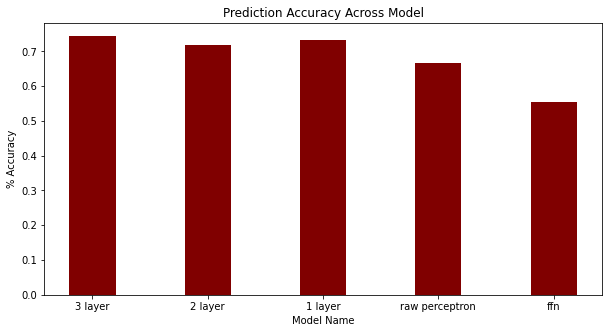

In [72]:
model_names = list(model_accuracy.keys())
model_values = list(model_accuracy.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(model_names, model_values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model Name")
plt.ylabel("% Accuracy")
plt.title("Prediction Accuracy Across Model")
plt.show()

#Robustness To Noise 
We will now inject some noise in the input images and see how much the representations learned by the RBM are robust to noise.

In [73]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

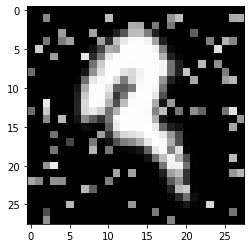

In [74]:
#sample of noise image 
noise_level = 0.1
emnist_test_with_noise = _inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28), cmap="gray")

We will now compute the hidden representations for the noisy images using the RBM. Then, we will use the models that we trained on the representations without noise to classify the noisy ones.

In [75]:
def _get_accuracy_values_at_noise_level(noise_level):
  emnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(emnist_test_with_noise, 0)  # here we compute the representations
  hidden_repr_layer_2_noisy = _get_kth_layer_repr(hidden_repr_layer_1_noisy, 1)  
  hidden_repr_layer_3_noisy = _get_kth_layer_repr(hidden_repr_layer_2_noisy, 2)  

  #prediction 
  pred_1_noisy = perceptron_1(hidden_repr_layer_1_noisy)
  pred_2_noisy = perceptron_2(hidden_repr_layer_2_noisy)
  pred_3_noisy = perceptron_3(hidden_repr_layer_3_noisy)
  pred_4_noisy = perceptron_4(emnist_test_with_noise.reshape((20800, 784))) 
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((20800, 784)))

  #accuracy 
  acc_1_noisy = _compute_accuracy(pred_1_noisy, emnist_targets_test)
  acc_2_noisy = _compute_accuracy(pred_2_noisy, emnist_targets_test)
  acc_3_noisy = _compute_accuracy(pred_3_noisy, emnist_targets_test)
  acc_4_noisy = _compute_accuracy(pred_4_noisy, emnist_targets_test)
  acc_ffn_noisy = _compute_accuracy(predictions_ffnn_noisy, emnist_targets_test)

  return acc_1_noisy, acc_2_noisy, acc_3_noisy, acc_4_noisy, acc_ffn_noisy

In [76]:
range_noise = [0.1,0.2,0.3,0.4,0.5,0.6]
acc_noise={}
for noise in range_noise: 
  acc_noise[noise] = list(_get_accuracy_values_at_noise_level(noise))

dbn_1_layer = []
dbn_2_layer = []
dbn_3_layer = []
perceptron_raw = []
ffn = []

for noise in range_noise: 
  dbn_1_layer.append(acc_noise[noise][0])
  dbn_2_layer.append(acc_noise[noise][1])
  dbn_3_layer.append(acc_noise[noise][2])
  perceptron_raw.append(acc_noise[noise][3])
  ffn.append(acc_noise[noise][4])

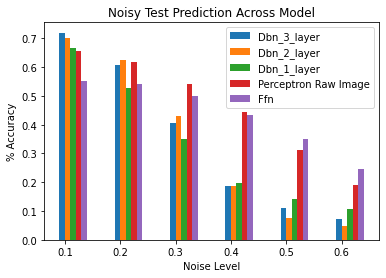

In [77]:
n=6
r = np.arange(n)
width = 0.1

plt.bar(r, dbn_3_layer, label = "Dbn_3_layer", width=width)
plt.bar(r+width, dbn_2_layer, label = "Dbn_2_layer", width=width)
plt.bar(r+2*width, dbn_1_layer, label = "Dbn_1_layer", width=width)

plt.bar(r+3*width, perceptron_raw,  label = "Perceptron Raw Image", width=width)
plt.bar(r+4*width, ffn,  label = "Ffn", width=width)

plt.xlabel("Noise Level")
plt.ylabel("% Accuracy")
plt.title("Noisy Test Prediction Across Model")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,range_noise)
plt.legend()
  
plt.show()

#Adversarial Attack 

##Fast Gradient Sign Method 

Reference: https://jaketae.github.io/study/fgsm/

In general, with adversarial attacks we need to modify the input so that the model cannot correctly classify it anymore. This means that the loss for that specific input has to increase.

The loss is usually a function of the input, the model's parameters and the outputs: $J(w, x, y)$.

When we are training the model, we modify the model's weights based on the value of the gradient of the loss function, using the opposite direction w.r.t. the gradient because we want the loss to decrease. To create an adversarial sample we change two things in this procedure: 
1. we modify the input instead of the model's weights;
2. we go in the same direction as the gradient, since we want the loss function to increase.

The adversarial sample will then look like:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [78]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

##Adversarial Sample

###DBN

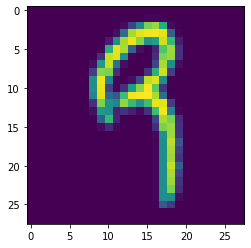

In [79]:
#Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

test_image = emnist_data_test[30].reshape(1,784) #reshape(1, 28, 28)
__ = plt.imshow(test_image.reshape(28,28))

In [80]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_emnist = dbn_emnist

    def forward(self, image):
        x, __ = self.dbn_emnist.forward(image)
        x = self.readout.forward(x)
        return x

In [81]:
def perturbed_dbn(input,target,idx,eps):
  perceptron_3_attack = perceptron_3 
  hidden_repr_layer_1_attack = _get_kth_layer_repr(input, 0)
  hidden_repr_layer_2_attack = _get_kth_layer_repr(hidden_repr_layer_1_attack, 1)
  hidden_repr_layer_3_attack = _get_kth_layer_repr(hidden_repr_layer_2_attack, 2)
  pred_1_attack = perceptron_3_attack(hidden_repr_layer_3_attack)

  prediction = torch.argmax(pred_1_attack)
  
  test_image_label = target #[idx]
  loss_value = torch.nn.functional.cross_entropy(pred_1_attack, test_image_label)
  perceptron_3_attack.zero_grad()
  test_image.requires_grad = True
  loss_value.backward()
  image_grad = test_image.grad.data
  perturbed_image = fgsm_attack(test_image, eps, image_grad)

  return prediction, perturbed_image 


In [82]:
def predict_dbn(input):
  perceptron_3_attack = perceptron_3 
  hidden_repr_layer_1_attack = _get_kth_layer_repr(input, 0)
  hidden_repr_layer_2_attack = _get_kth_layer_repr(hidden_repr_layer_1_attack, 1)
  hidden_repr_layer_3_attack = _get_kth_layer_repr(hidden_repr_layer_2_attack, 2)
  pred_1_attack = perceptron_3_attack(hidden_repr_layer_3_attack)

  prediction = torch.argmax(pred_1_attack)
  return prediction

In [84]:
perceptron_3_attack = perceptron_3 
hidden_repr_layer_1_attack = _get_kth_layer_repr(test_image, 0)
hidden_repr_layer_2_attack = _get_kth_layer_repr(hidden_repr_layer_1_attack, 1)
hidden_repr_layer_3_attack = _get_kth_layer_repr(hidden_repr_layer_2_attack, 2)
pred_1_attack = perceptron_3_attack(hidden_repr_layer_3_attack)

prediction = torch.argmax(pred_1_attack)
print(f"The prediction of the model for this sample is {lbl[prediction]}.")
print(f"The correct answer for this sample is {lbl[emnist_targets_test[30]]}.") 

test_image_label = emnist_test.targets[30:31]
loss_value = torch.nn.functional.cross_entropy(pred_1_attack, test_image_label)
perceptron_3_attack.zero_grad()
test_image.requires_grad = True
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)


The prediction of the model for this sample is a.
The correct answer for this sample is a.


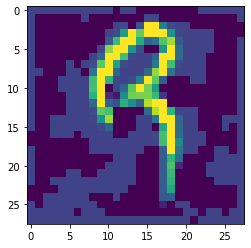

In [85]:
#Let's look at the adversarial sample:
perturbed_image_np = perturbed_image.detach().numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [86]:
#model_outputs = perceptron_3_attack(perturbed_image.view((perturbed_image.shape[0], -1)))
model_outputs = predict_dbn(perturbed_image)
print(f"The prediction of the model for the perturbed sample is {lbl[torch.argmax(model_outputs)]}.")
print(f"The correct answer for this sample is {lbl[emnist_targets_test[30]]}.") 

The prediction of the model for the perturbed sample is a.
The correct answer for this sample is a.


###Raw Perceptron

In [87]:
test_image = emnist_data_test[30].reshape(1,784) #reshape(1, 28, 28)

In [88]:
attacked_model = perceptron_4
test_image.requires_grad = True
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {lbl[prediction]}.")
print(f"The correct answer for this sample is {lbl[emnist_targets_test[30]]}.") 

test_image_label = emnist_test.targets[30:31]
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

The prediction of the model for this sample is a.
The correct answer for this sample is a.


In [89]:
perturbed_image_np = perturbed_image.detach().numpy()
#__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [90]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {lbl[torch.argmax(model_outputs)]}.")
print(f"The correct answer for this sample is {lbl[emnist_test.targets[30]]}.") 

The prediction of the model for the perturbed sample is a.
The correct answer for this sample is b.


###FFNN

In [91]:
test_image = emnist_data_test[30].reshape(1,784) #.reshape(1, 28, 28)
attacked_model = ffnn
test_image.requires_grad = True
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this sample is {lbl[prediction]}.")
print(f"The correct answer for this sample is {lbl[emnist_targets_test[30]]}.") 

test_image_label = emnist_test.targets[30:31]
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data
perturbed_image = fgsm_attack(test_image, 0.2, image_grad)

The prediction of the model for this sample is w.
The correct answer for this sample is a.


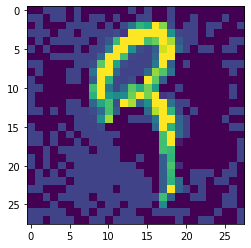

In [92]:
#Let's look at the adversarial sample:

perturbed_image_np = perturbed_image.detach().numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [93]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {lbl[torch.argmax(model_outputs)]}.")
print(f"The correct answer for this sample is {lbl[emnist_targets_test[30]]}.") 

The prediction of the model for the perturbed sample is m.
The correct answer for this sample is a.


##Resisting to Adversarial Attack 
Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the RBM.

We will also test the ability of the RBM to reduce the impact of the attack by performing one or more reconstruction steps, from the hidden representation to the visible units, and back to the hidden representation.

In [94]:
def test_robustness_to_attack_dbn(device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0
    i=0
    for data, target in tqdm.tqdm(test_loader):
        data = emnist_data_test[i]
        target = emnist_test.targets[i:i+1] - 1
        data = data.reshape(1,784)
        
        output, perturbed_data = perturbed_dbn(data,target,i,epsilon)
        i+=1

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()


        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = predict_dbn(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        if output == target:
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))
    return final_acc

In [95]:
test_loader = torch.utils.data.DataLoader(emnist_test)

In [96]:
#Let's see how good the FFNN does:
device = torch.device("cpu")

In [97]:
#DBN
final_acc_dbn = test_robustness_to_attack_dbn(device,
                                      test_loader, epsilon=0.0001,
                                      num_steps=0)

100%|██████████| 20800/20800 [00:30<00:00, 688.61it/s]


Epsilon: 0.0001	Test Accuracy = 800 / 20800 = 0.038461538461538464



In [98]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        target = target - 1
        if model == perceptron_4:
          data = data.reshape(1,784)
        else: 
          data = data.reshape(1, 28, 28)

        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))
    return final_acc

In [99]:
#ffn
final_acc_ffn = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.0001,
                                      num_steps=0)

100%|██████████| 20800/20800 [00:12<00:00, 1688.64it/s]


Epsilon: 0.0001	Test Accuracy = 983 / 20800 = 0.047259615384615386



In [100]:
#Raw Perceptron

final_acc = test_robustness_to_attack(perceptron_4, device,
                                      test_loader, epsilon=0.0001, 
                                      num_steps=0)

100%|██████████| 20800/20800 [00:06<00:00, 3067.60it/s]


Epsilon: 0.0001	Test Accuracy = 1027 / 20800 = 0.049375



Now, let's see the effect of data reconstruction of DBN 

  0%|          | 0/20800 [00:00<?, ?it/s]


Here's the original sample:



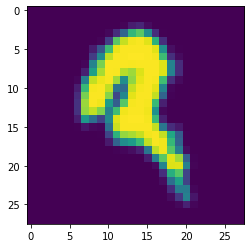


Here's a perturbed sample:



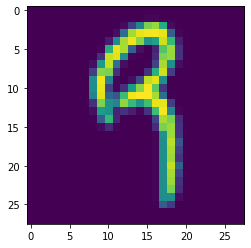


Here's what a 1-steps reconstructed sample looks like:



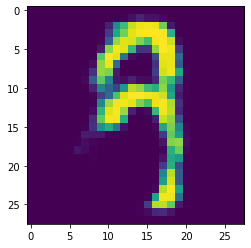

100%|██████████| 20800/20800 [00:32<00:00, 633.90it/s]


Epsilon: 0.0001	Test Accuracy = 463 / 20800 = 0.022259615384615385



In [101]:
#Now let's test the reconstruction power of the generative model:

#DBN
final_acc_dbn = test_robustness_to_attack_dbn(device,
                                      test_loader, epsilon=0.0001,
                                      num_steps=1)

## Effect of the parameter $\epsilon$
Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [102]:
epsilon_values = [0, .0001, .0005, .001, .005, 0.01]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()
  if model == 'dbn':
    for eps in epsilon_values:
      acc = test_robustness_to_attack_dbn(device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)
  else:
    for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [103]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)

In [104]:
accuracies_dbn = test_epsilon_values_effect('dbn', n_steps=0)

100%|██████████| 20800/20800 [00:31<00:00, 664.28it/s]


In [105]:
accuracies_dbn_1 = test_epsilon_values_effect('dbn', n_steps=1)

100%|██████████| 20800/20800 [00:31<00:00, 656.40it/s]


In [106]:
accuracies_dbn_1 

[0.020096153846153847,
 0.020913461538461537,
 0.020817307692307694,
 0.020384615384615383,
 0.022163461538461538,
 0.02076923076923077]

In [107]:
accuracies_raw_perceptron = test_epsilon_values_effect(perceptron_4, n_steps=0)

100%|██████████| 20800/20800 [00:06<00:00, 3080.86it/s]


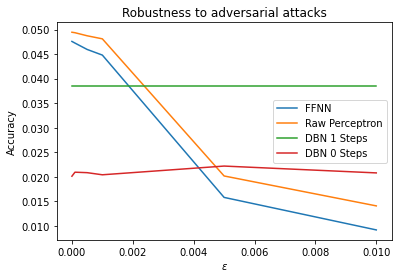

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_raw_perceptron)
__ = ax.plot(epsilon_values, accuracies_dbn)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
__ = ax.legend(["FFNN", "Raw Perceptron", "DBN 1 Steps","DBN 0 Steps"])

Text(0.5, 51.0, 'Predicted')

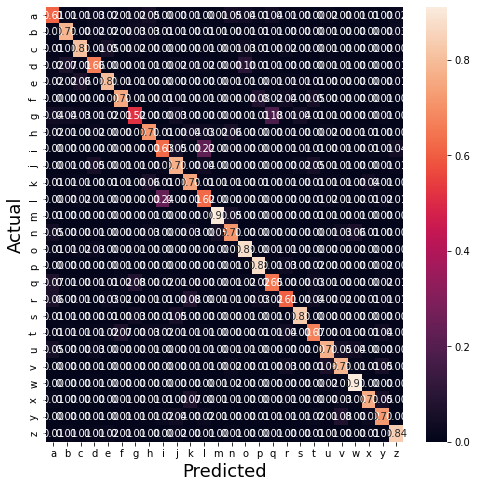

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = predictions_test_3.max(axis = 1).indices 

conf_mat = confusion_matrix(
        emnist_targets_test,
        pred.detach().numpy(),
        #labels = np.unique(emnist_targets_test),
        normalize = 'true'
    )

_, ax = plt.subplots(figsize = (8, 8))
sns.heatmap(
    conf_mat, 
    annot = True, 
    fmt = '.2f',
    xticklabels=np.unique(lbl),
    yticklabels=np.unique(lbl)
)
plt.ylabel('Actual', fontsize = 18)
plt.xlabel('Predicted', fontsize = 18)
#plt.title(f'Perceptron: {n_layer + 1} hidden layer', fontsize = 18)